In [90]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip
/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip


In [91]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set_style("white", {'ytick.major.size': 8.0})
sns.set_context("poster", font_scale=0.5)

I wanted to take a look at the user data we have for this competition so I made this little notebook to share my findings and discuss about those. At the moment I've started with the basic user data, I'll take a look at sessions and the other csv files later on this month.

Please, feel free to comment with anything you think it can be improved or fixed. I am not a professional in this field and there will be mistakes or things that can be improved. This is the flow I took and there are some plots not really interesting but I thought on keeping it in case someone see something interesting.

Let's see the data!

### Data Exploration
Generally, when I start with a Data Science project I'm looking to answer the questions:
- Is there any mistakes in the data?
- Does the data have peculiar behavior?
- Do I need to fix or remove any of the data to be more realistic?

In [92]:
# Load the data into DataFrames
train_users = pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/train_users_2.csv.zip')
test_users = pd.read_csv('/kaggle/input/airbnb-recruiting-new-user-bookings/test_users.csv.zip')
# /kaggle/input/airbnb-recruiting-new-user-bookings/sample_submission_NDF.csv.zip
# /kaggle/input/airbnb-recruiting-new-user-bookings/age_gender_bkts.csv.zip
# /kaggle/input/airbnb-recruiting-new-user-bookings/countries.csv.zip
# /kaggle/input/airbnb-recruiting-new-user-bookings/sessions.csv.zip


In [93]:
print("We have", train_users.shape[0], "users in the training set and", 
     test_users.shape[0], "in the test set.")
print("In total we have", train_users.shape[0] + test_users.shape[0], "users.")

We have 213451 users in the training set and 62096 in the test set.
In total we have 275547 users.


Let's get those together so we can work with all the data.

In [94]:
# Merge train and test users
users = pd.concat((train_users, test_users), axis=0, ignore_index=True)

# Remove ID's since now we are not interested in making predictions
users.drop('id', axis=1, inplace=True)

users.head()

,date_account_created,timestamp_first_active,date_first_booking,gender,age,signup_method,signup_flow,language,affiliate_channel,affiliate_provider,first_affiliate_tracked,signup_app,first_device_type,first_browser,country_destination
0,2010-06-28,20090319043255,NaN,-unknown-,NaN,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,NDF
1,2011-05-25,20090523174809,NaN,MALE,38.0,facebook,0,en,seo,google,untracked,Web,Mac Desktop,Chrome,NDF
2,2010-09-28,20090609231247,2010-08-02,FEMALE,56.0,basic,3,en,direct,direct,untracked,Web,Windows Desktop,IE,US
3,2011-12-05,20091031060129,2012-09-08,FEMALE,42.0,facebook,0,en,direct,direct,untracked,Web,Mac Desktop,Firefox,other
4,2010-09-14,20091208061105,2010-02-18,-unknown-,41.0,basic,0,en,direct,direct,untracked,Web,Mac Desktop,Chrome,US


The data seems to be in an ussable format so the next important thing is to take a look at the missing data.

### Missing Data

Usually the missing data comes in the way of NaN, but if we take a look at the DataFrame printed above we can see at the ```gender``` column some values being ```-unknown-```. We will need to transform those values into NaN first:

In [97]:
users.gender.replace('-unknown-', np.nan, inplace=True)

Now let's see how much data we are missing. For this purpose let's compute the NaN percentage of each feature.

In [98]:
users_nan = (users.isnull().sum() / users.shape[0]) * 100

In [99]:
users_nan[users_nan > 0]

date_first_booking         67.733998
gender                     46.990169
age                        42.412365
first_affiliate_tracked     2.208335
country_destination        22.535538
dtype: float64

In [100]:
users_nan[users_nan > 0].drop('country_destination')

date_first_booking         67.733998
gender                     46.990169
age                        42.412365
first_affiliate_tracked     2.208335
dtype: float64

We have quite a lot of NaN in the ```age``` and ```gender``` which will yield in lesser performance of the classifiers we will build. The feature ```date_first_booking``` has a 58% of NaN values because this feature is not present at the tests users, and therefore, we won't need it at the *modeling* part.

In [101]:
users_nana = (test_users.isnull().sum() / test_users.shape[0]) * 100
users_nana

id                           0.000000
date_account_created         0.000000
timestamp_first_active       0.000000
date_first_booking         100.000000
gender                       0.000000
age                         46.502190
signup_method                0.000000
signup_flow                  0.000000
language                     0.000000
affiliate_channel            0.000000
affiliate_provider           0.000000
first_affiliate_tracked      0.032208
signup_app                   0.000000
first_device_type            0.000000
first_browser                0.000000
dtype: float64

In [102]:
print("Just for the sake of curiosity; we have",
     int((train_users.date_first_booking.isnull().sum() / train_users.shape[0]) * 100),
     "% of missing values at date_first_booking in the training data")

Just for the sake of curiosity; we have 58 % of missing values at date_first_booking in the training data


The other feature with a high rate of NaN was ```age```. Let's see:

In [103]:
users.age.describe()

count    158681.000000
mean         47.145310
std         142.629468
min           1.000000
25%          28.000000
50%          33.000000
75%          42.000000
max        2014.000000
Name: age, dtype: float64

There is some inconsistency in the age of some users as we can see above. It could be because the ```age``` input field was not sanitized or there was some mistakes handling the data.

In [104]:
print(sum(users.age > 122))
print(sum(users.age < 18))

830
188


So far, do we have 801 users with [the longest confirmed human lifespan record](https://en.wikipedia.org/wiki/Jeanne_Calment) and 176 little gangsters breaking the [Airbnb Eligibility Teams](https://www.airbnb.co.kr/help/article/2003)?

In [105]:
users[users.age > 122]['age'].describe()

count     830.000000
mean     2002.620482
std        94.201344
min       132.000000
25%      2014.000000
50%      2014.000000
75%      2014.000000
max      2014.000000
Name: age, dtype: float64

It's seems that the weird values are caused by appearance of 2014. I didn't figured why, but I suppose that might be related with a wrong input being added with the new users.

In [106]:
users[users.age < 18]['age'].describe()

count    188.000000
mean      12.718085
std        5.764569
min        1.000000
25%        5.000000
50%       16.000000
75%       17.000000
max       17.000000
Name: age, dtype: float64

The young users seems to be under an acceptable range being the 50% of those users above 16 years old. We will need to hande the outliers. The simple thing that came to my mind it's to set an acceptance range and put those out of it to NaN.

In [107]:
users.loc[users.age > 95, 'age'] = np.nan
users.loc[users.age < 13, 'age'] = np.nan

### Data Types

Let's treat each features as what they are. This means we need to transform into categorical those features that we treat as categories and the same with dates:

In [108]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype  
---  ------                   --------------   -----  
 0   date_account_created     275547 non-null  object 
 1   timestamp_first_active   275547 non-null  int64  
 2   date_first_booking       88908 non-null   object 
 3   gender                   146067 non-null  object 
 4   age                      155825 non-null  float64
 5   signup_method            275547 non-null  object 
 6   signup_flow              275547 non-null  int64  
 7   language                 275547 non-null  object 
 8   affiliate_channel        275547 non-null  object 
 9   affiliate_provider       275547 non-null  object 
 10  first_affiliate_tracked  269462 non-null  object 
 11  signup_app               275547 non-null  object 
 12  first_device_type        275547 non-null  object 
 13  first_browser            275547 non-null  object 
 14  coun

In [109]:
categorical_features = [
    'affiliate_channel',
    'affiliate_provider',
    'country_destination',
    'first_affiliate_tracked',
    'first_browser',
    'first_device_type',
    'gender',
    'language',
    'signup_app',
    'signup_method'
]

for categorical_feature in categorical_features:
    users[categorical_feature] = users[categorical_feature].astype('category')

In [110]:
users.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 275547 entries, 0 to 275546
Data columns (total 15 columns):
 #   Column                   Non-Null Count   Dtype   
---  ------                   --------------   -----   
 0   date_account_created     275547 non-null  object  
 1   timestamp_first_active   275547 non-null  int64   
 2   date_first_booking       88908 non-null   object  
 3   gender                   146067 non-null  category
 4   age                      155825 non-null  float64 
 5   signup_method            275547 non-null  category
 6   signup_flow              275547 non-null  int64   
 7   language                 275547 non-null  category
 8   affiliate_channel        275547 non-null  category
 9   affiliate_provider       275547 non-null  category
 10  first_affiliate_tracked  269462 non-null  category
 11  signup_app               275547 non-null  category
 12  first_device_type        275547 non-null  category
 13  first_browser            275547 non-null  ca

In [111]:
users['date_account_created'] = pd.to_datetime(users['date_account_created'])
users['date_first_booking'] = pd.to_datetime(users['date_first_booking'])
users['date_first_active'] = pd.to_datetime((users.timestamp_first_active // 1000000), format='%Y%m%d')

### Visualizing the Data
<br/>
Usually, looking at tables, percentiles, means, and other several measures at this state is rarely useful unless you know very well your data. <br/>
For me, it's usually better to visualize the data in some way. Visualization makes me see the outliers and errors immediately!

Gender

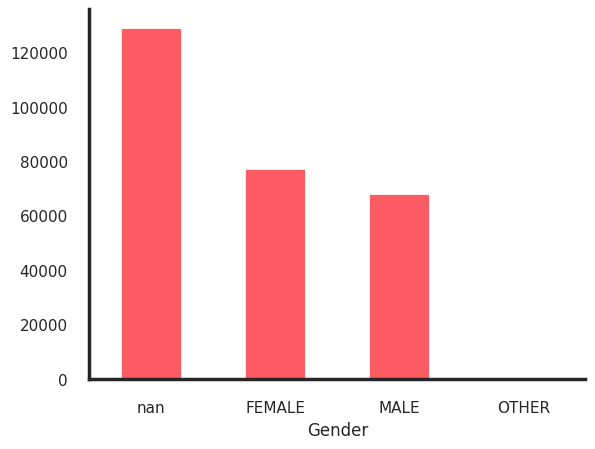

In [112]:
users.gender.value_counts(dropna=False).plot(kind='bar', color='#FD5C64', rot=0)
plt.xlabel('Gender')
sns.despine();

As we've seen before at this plot we can see the ammount of missing data in perspective. Also, notice that there is a slight difference between user gender.
<br/>
Next thing it might be intereseting to see if there is any gender preferences when travelling:

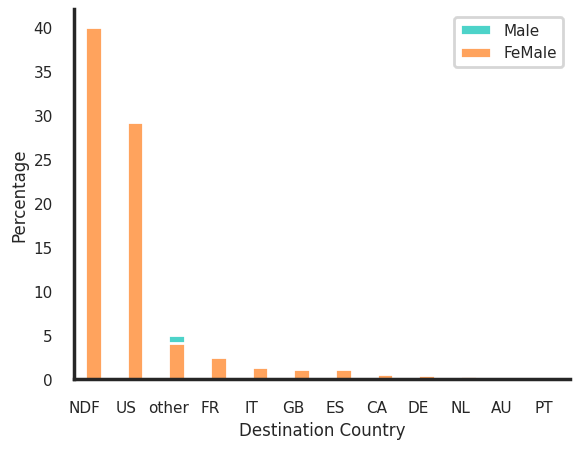

In [113]:
women = sum(users['gender'] == 'FEMALE')
men = sum(users['gender'] == 'MALE')

female_destinations = users.loc[users['gender'] == 'FEMALE', 'country_destination'].value_counts() / women * 100
male_destinations = users.loc[users['gender'] == 'MALE', 'country_destination'].value_counts() / men * 100

# Bar width
width = 0.4

male_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=0, label='Male', rot=0)
female_destinations.plot(kind='bar', width=width, color='#FFA35D', position=0, label='FeMale', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()              
                       
                       
                       

There are no big differences between the 2 main genders, so this plot it's not really useful except to know the relative destination frequency of the countries. Let's see it clear here:

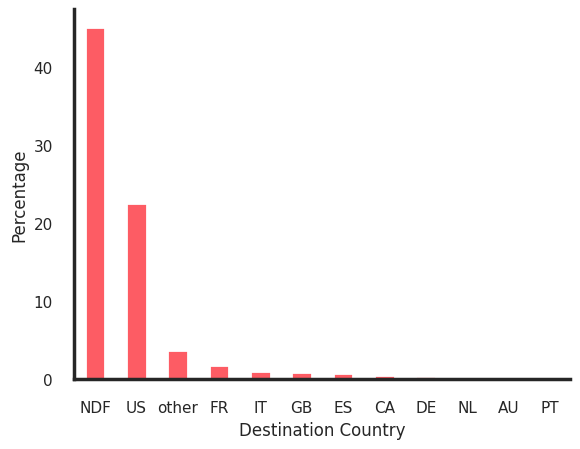

In [114]:
destination_percentage = users.country_destination.value_counts() / users.shape[0] * 100
destination_percentage.plot(kind='bar', color='#FD5C64', rot=0)
# Using seaborn can also be plotted
# sns.countplot(x="country_destination", data=users, order=list(users.country_destination.value_counts().keys()))
plt.xlabel('Destination Country')
plt.ylabel('Percentage')
sns.despine()

The first thing we can see that if there is a reservation, it's likely to be inside the US. But there is a 45% of people that never did a reservation.


**Age**
<br/>
<br/>

Now that I know there is no difference between male and female reservations at first sight I'll dig into the age.

In [ ]:
!conda update seaborn
!conda update pandas

/tmp/ipykernel_33/3156399525.py:1: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(users.age.dropna(), color='#FD5C64')
/opt/conda/lib/python3.10/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


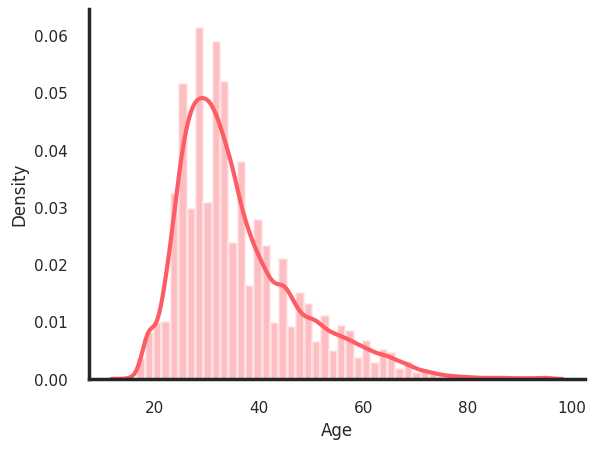

In [115]:
sns.distplot(users.age.dropna(), color='#FD5C64')
plt.xlabel('Age')
sns.despine()

As expected, the common age to travel is between 25 and 40. Let's see if, for example, older people travel in a different way. Let's pick an arbitrary age to split into two groups. Maybe 45?

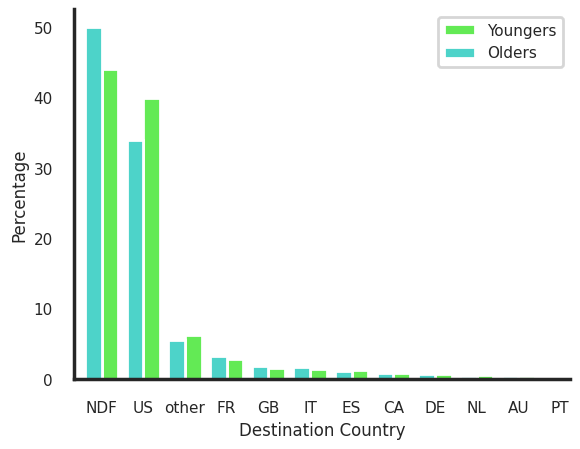

In [116]:
age = 45

younger = sum(users.loc[users['age'] < age, 'country_destination'].value_counts())
older = sum(users.loc[users['age'] > age, 'country_destination'].value_counts())

younger_destinations = users.loc[users['age'] < age, 'country_destination'].value_counts() / younger * 100
older_destinations = users.loc[users['age'] > age, 'country_destination'].value_counts() / older * 100

younger_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Youngers', rot=0)
older_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='Olders', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

We can see that the young people tends to stay in the US, and the older people choose to travel outside the country. Of course, there are no big differences between them and we must remember that we do not have the 42% of the ages.

The first thing I thought when reading the problem was the importance of the native language when choosing the destination country. So let's see how many users use english as main language:

In [117]:
print((sum(users.language == 'en') / users.shape[0])*100)

96.3675888323952


With the 96% of users using English as their language, it is understandable that a lot of people stay in the US. Someone maybe thinking, if the language is important, why not travel to GB? We need to remember that there is also a lot of factor we are not acounting so making assumptions or predictions like that might be dangerous.

**Dates**

To see the dates of our users and the timespan of them, let's plot the number of accounts created by time:

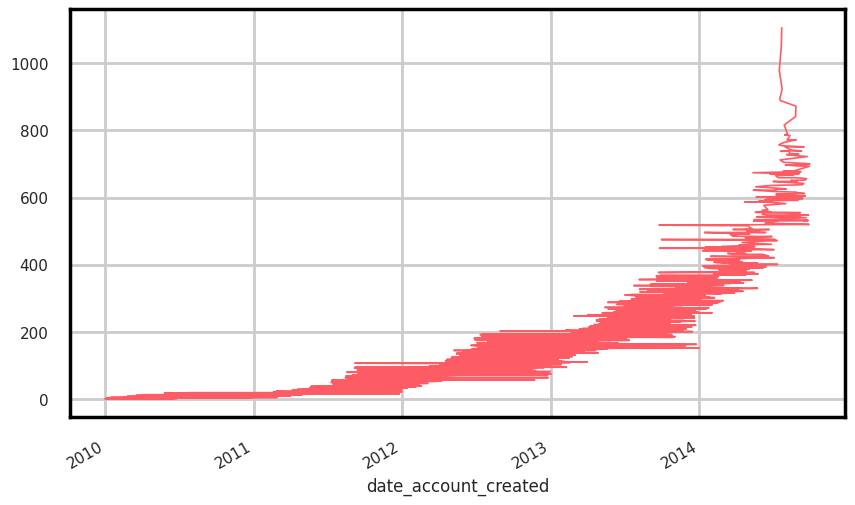

In [118]:
plt.figure(figsize=(10, 6))

sns.set_style('whitegrid', {'axes.edgecolor' : '0'})
sns.set_context("poster", font_scale=0.5)
users.date_account_created.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')
plt.show()

It's appreciable how fast Airbnb has grown over the last 3 years. Does this correlate with the date when the user was active for the first time? It should be very similar, so doing this is a way to check the data!

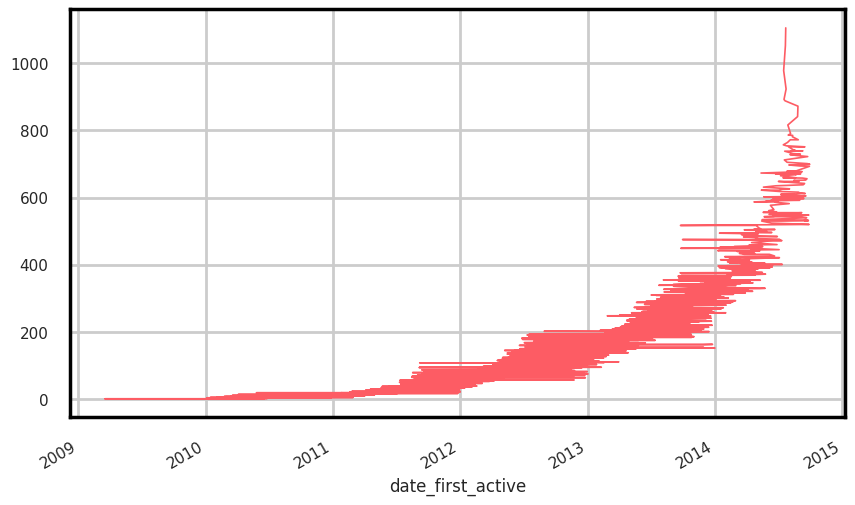

In [119]:
plt.figure(figsize=(10, 6))
users.date_first_active.value_counts().plot(kind='line', linewidth=1.2, color='#FD5C64')
plt.show()

We can see that's almost the same as ```date_account_created```, and also, notice the small peaks. We can, either smooth the graph or dig into those peaks. Let's dig in:

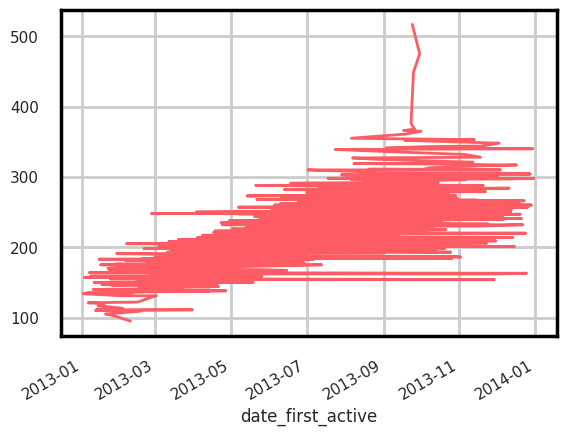

In [120]:
users_2013 = users[users['date_first_active'] > pd.to_datetime(20130101, format='%Y%m%d')]
users_2013 = users_2013[users_2013['date_first_active'] < pd.to_datetime(20140101, format='%Y%m%d')]
users_2013.date_first_active.value_counts().plot(kind='line', linewidth=2, color='#FD5C64')
plt.show()

At first sight we can see a small pattern, there are some peaks at the same distance. Looking more closely:

In [121]:
weekdays = []
for date in users.date_account_created:
    weekdays.append(date.weekday())
weekdays = pd.Series(weekdays)

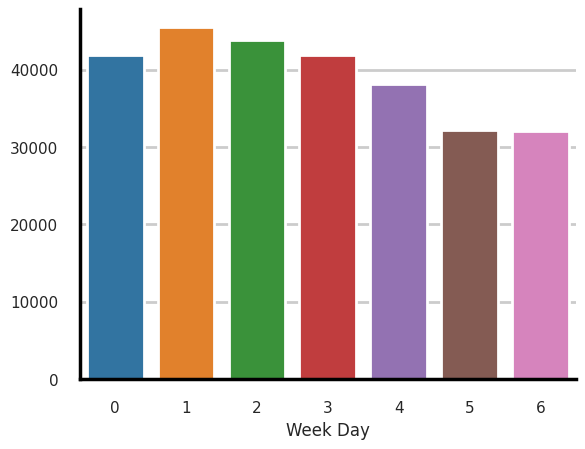

In [123]:
sns.barplot(x = weekdays.value_counts().index, y=weekdays.value_counts().values, order=range(0,7))
plt.xlabel('Week Day')
sns.despine()

The local minimums where the Sundays(where the people use less the Internet), and it's usually to hit a maximum at Tuesdays!
The last date related plot I want to see is the next:

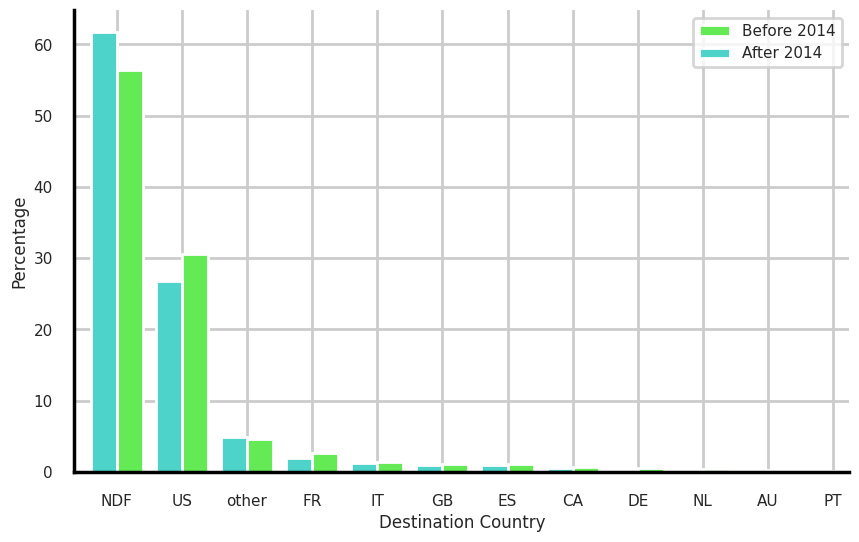

In [125]:
plt.figure(figsize=(10,6))
date = pd.to_datetime(20140101, format='%Y%m%d')

before = sum(users.loc[users['date_first_active'] < date, 'country_destination'].value_counts())
after = sum(users.loc[users['date_first_active'] > date, 'country_destination'].value_counts())
before_destinations = users.loc[users['date_first_active'] < date,
                               'country_destination'].value_counts() / before * 100
after_destinations = users.loc[users['date_first_active'] > date,
                               'country_destination'].value_counts() / after * 100
before_destinations.plot(kind='bar', width=width, color='#63EA55', position=0, label='Before 2014', rot=0)
after_destinations.plot(kind='bar', width=width, color='#4DD3C9', position=1, label='After 2014', rot=0)

plt.legend()
plt.xlabel('Destination Country')
plt.ylabel('Percentage')

sns.despine()
plt.show()

It's clean comparison of usual destinations then and now, where we can see how the users, register more and book less, and when they stay at the US.